In [1]:
import os
import gc
import sys
import time
import json
import math
import shutil
import logging
import random
import warnings
import joblib
import wandb
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime
from moviepy import *  # latest version
from typing import Union, List, Dict, Any, Tuple, Optional, Callable, Iterable
# from dotenv import load_dotenv

# Security & Cryptography
from Crypto.Random import random as crandom  # pip install pycryptodome

import matplotlib.pyplot as plt
import seaborn as sns

# Logger
# from codejournal.loggers import logger, train_logger, slack_logger

sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
tqdm.pandas()

# if os.path.exists(".env"):
#     logger.info("Loading .env file")
#     load_dotenv()


import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class VQ(nn.Module):
    
    def __init__(self,num_embeddings=512,embedding_dim=64,commitment_cost=0.25):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        
        self.embeddings = nn.Embedding(self.num_embeddings,self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings,1/self.num_embeddings)
    
    def forward(self,inputs):
        inputs = inputs.permute(0,2,3,1).contiguous()
        input_shape = inputs.shape
        
        flat_inputs = inputs.view(-1,self.embedding_dim)
        
        distances = torch.cdist(flat_inputs,self.embeddings.weight)
        encoding_index = torch.argmin(distances,dim=1) 
        
        quantized = torch.index_select(self.embeddings.weight,0,encoding_index).view(input_shape)
        
        e_latent_loss = F.mse_loss(quantized.detach(),inputs)
        q_latent_loss = F.mse_loss(quantized,inputs.detach())
        c_loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        
        quantized = quantized.permute(0,3,1,2).contiguous()
        return c_loss, quantized

class ResudialBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels):
        super(ResudialBlock,self).__init__()
        self.resblock = nn.Sequential(nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels,hidden_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(hidden_channels,out_channels,kernel_size=1,stride=1,bias=False))
    def forward(self,x):
        return x + self.resblock(x)

class ResudialStack(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels,num_res_layers):
        super(ResudialStack,self).__init__()
        self.num_res_layers = num_res_layers
        self.layers = nn.ModuleList([ResudialBlock(in_channels,out_channels,hidden_channels) for _ in range(num_res_layers)])
    
    def forward(self,x):
        for i in range(self.num_res_layers):
            x = self.layers[i](x)
        return F.relu(x)

class Model(nn.Module):

    def __init__(self,num_embeddings=512,embedding_dim=64,commitment_cost=0.25):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        #encode
        self.conv1 = nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
        self.conv3 = nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
        self.resblock1 = ResudialStack(128,128,64,3)
        
        #vq 
        self.vq_conv = nn.Conv2d(128,self.embedding_dim,kernel_size=1,stride=1)
        self.vq = VQ(self.num_embeddings,self.embedding_dim,self.commitment_cost)
        
        #decode
        self.conv4 = nn.Conv2d(self.embedding_dim,64,kernel_size=3,stride=1,padding=1)
        self.resblock2 = ResudialStack(64,64,32,3)
        self.conv5 = nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.conv6 = nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding=1)


    def encode(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.resblock1(x)
        return x
        
    def decode(self,quantized):
        x = self.conv4(quantized)
        x = self.resblock2(x)
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        return x

    def forward(self,inputs):
        x = self.encode(inputs)
        c_loss,quantized =  self.vq(self.vq_conv(x))
        outputs = self.decode(quantized)
        rec_loss = F.mse_loss(outputs,inputs)
        loss = rec_loss + c_loss
        return loss,outputs,rec_loss

In [3]:
model = Model()

In [4]:
wts = torch.load('/kaggle/input/training-vq-vae-on-imagenet-pytorch-tpu/imagenet_vq_vae_model.bin')
model.load_state_dict(wts)

<All keys matched successfully>

# Data

In [5]:
classes = os.listdir('/kaggle/input/imagenet100/train.X1')
data = {}
for _class in classes:
    imgs = os.listdir(f'/kaggle/input/imagenet100/train.X1/{_class}')
    data[_class] = [f'/kaggle/input/imagenet100/train.X1/{_class}/{img}' for img in imgs]

In [6]:
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A 
import cv2

def get_train_transforms():
    return A.Compose(
        [
            A.Resize(512,512,always_apply=True),
            A.Normalize(),
            ToTensorV2(p=1.0)
        ])


class ImageNetDataset(Dataset):
    def __init__(self,paths,augmentations):
        self.paths = paths
        self.classes = list(paths.keys())
        self.augmentations = augmentations
    
    def __getitem__(self,idx):
        class_ = random.choice(self.classes)
        path = self.paths[class_][idx%1300]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']
        
        return image, class_
    
    def __len__(self):
        return len(self.paths) * 1300

In [7]:
dataset = ImageNetDataset(data, get_train_transforms())

In [8]:
image, class_ = dataset[0]

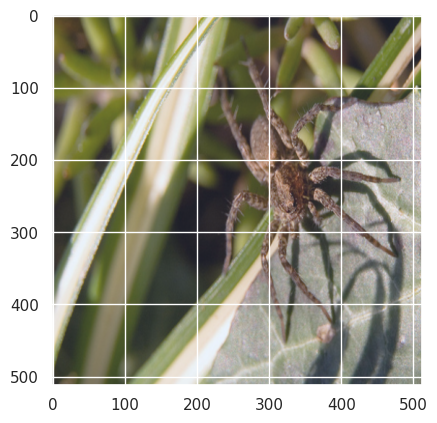

In [9]:
plt.imshow(((image.permute(1,2,0)/ (image.max()) + 1)/2))

In [10]:
test_dl = DataLoader(dataset,batch_size=16,shuffle=False,num_workers=4)

In [11]:
import uuid
model.cuda()
model.eval()
for batch in tqdm(test_dl):
    X,y = batch
    X = X.cuda()
    _,outputs,_ =  model(X)
    outputs = outputs.detach().cpu()
    outputs = ((outputs.permute(0,2,3,1)/ (outputs.max()) + 1)/2)
    outputs = outputs.clip(0,1)
    
    for x,label in zip(outputs,y):
        os.makedirs(f'recon_dataset/{label}', exist_ok=True)
        plt.imsave(f'recon_dataset/{label}/{str(uuid.uuid4())}.jpg', x.numpy())

  0%|          | 0/2032 [00:00<?, ?it/s]